<a href="https://colab.research.google.com/github/pedro-pauletti/nlp-with-transformers/blob/main/Projects/Sentiment_Model_With_TensorFlow_and_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Requirements

In [ ]:
!pip install kaggle transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.0 MB/s eta 0:00:00


### Getting the Data (Kaggle API)

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [ ]:
api = KaggleApi()

In [ ]:
api.authenticate()

In [ ]:
import zipfile
import os

for file in ['train.tsv', 'test.tsv']:
    api.competition_download_file('sentiment-analysis-on-movie-reviews', f'{file}.zip', path='./')

    with zipfile.ZipFile(f'{file}.zip', 'r') as zip_ref:
        zip_ref.extractall('./')

    os.remove(f'{file}.zip')

100%|██████████| 1.28M/1.28M [00:00<00:00, 2.18MB/s]


100%|██████████| 494k/494k [00:00<00:00, 1.08MB/s]

### Preprocessing

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('train.tsv', sep="\t")
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [ ]:
#df.drop_duplicates(subset=["SentenceId"], keep='first')

The sentiment labels are:

0 - negative

1 - somewhat negative

2 - neutral

3 - somewhat positive

4 - positive

<Axes: >

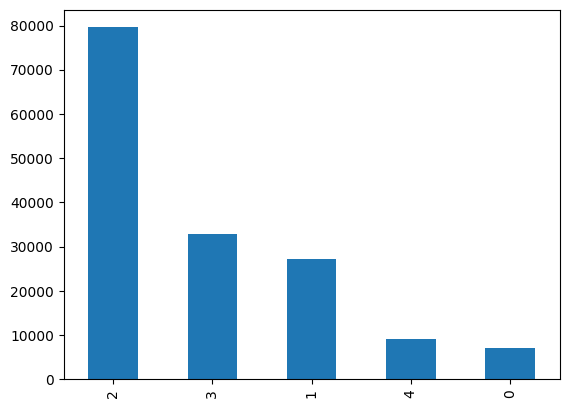

In [ ]:
df['Sentiment'].value_counts().plot(kind='bar')

In [ ]:
seq_len = 512
num_samples = len(df)

num_samples, seq_len

(156060, 512)

In [ ]:
from transformers import BertTokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
tokens = tokenizer(df['Phrase'].tolist(), max_length=seq_len,
                   truncation=True, padding='max_length',
                   add_special_tokens=True,
                   return_tensors='np')

In [ ]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
tokens['input_ids']

array([[  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       ...,
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101, 22572, 12148, ...,     0,     0,     0]])

In [ ]:
tokens['attention_mask']

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [ ]:
import numpy as np

with open('movie-xids.npy', 'wb') as f:
  np.save(f, tokens['input_ids'])
with open('movie-xmask.npy', 'wb') as f:
  np.save(f, tokens['attention_mask'])

In [ ]:
arr = df['Sentiment'].values

In [ ]:
arr.shape

(156060,)

In [ ]:
arr

array([1, 2, 2, ..., 3, 2, 2])

In [ ]:
arr.max()+1

5

2 = [0,0,1,0,0]

4 = [0,0,0,0,1]

In [ ]:
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(156060, 5)

In [ ]:
labels

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [ ]:
labels[np.arange(num_samples), arr] = 1
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [ ]:
with open('movie-labels.npy', 'wb') as f:
  np.save(f, labels)

### Building a Dataset

In [ ]:
with open('movie-xids.npy', 'rb') as f:
  Xids = np.load(f, allow_pickle=True)
with open('movie-xmask.npy', 'rb') as f:
  Xmask = np.load(f, allow_pickle=True)
with open('movie-labels.npy', 'rb') as f:
  labels = np.load(f, allow_pickle=True)

In [ ]:
import tensorflow as tf

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

In [ ]:
dataset.take(0)

<_TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

{input_ids, attention_mask}, outputs

In [ ]:
def map_func(input_ids, masks, labels):
  return {'input_ids': input_ids,
          'attention_mask': masks}, labels

In [ ]:
dataset = dataset.map(map_func)

In [ ]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int64, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

### Data Shuffle, Batch, Split, and Save

In [ ]:
batch_size = 16

In [ ]:
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

In [ ]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [ ]:
split = 0.9

In [ ]:
size = int((Xids.shape[0] / batch_size) * split)

In [ ]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

In [ ]:
tf.data.experimental.save(train_ds, 'train')
tf.data.experimental.save(val_ds, 'val')

Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.


In [ ]:
train_ds.element_spec

({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
  'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [ ]:
train_ds.element_spec == val_ds.element_spec

True

In [ ]:
ds = tf.data.experimental.load('train', element_spec=train_ds.element_spec)

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


In [ ]:
ds.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

### Build and Save

In [ ]:
from transformers import TFAutoModel

In [ ]:
bert = TFAutoModel.from_pretrained('bert-base-cased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108310272 (413.17 MB)
Trainable params: 108310272 (413.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
import tensorflow as tf

In [ ]:
#two inputs
input_ids = tf.keras.layers.Input(shape=(512,),
                                  name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,),
                                  name='attention_mask', dtype='int32')

#transformers
embeddings = bert.bert(input_ids, attention_mask=mask)[1]

#classifier head
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)

In [ ]:
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 512, 7                                       

In [ ]:
model.layers[2].trainable = False

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 512, 7                                       

In [ ]:
optimizer = tf.keras.optimizers.legacy.Adam(lr=1e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
element_spec=({'input_ids': tf.TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
               'attention_mask': tf.TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
               tf.TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [ ]:
train_ds = tf.data.experimental.load('train', element_spec=element_spec)
val_ds = tf.data.experimental.load('val', element_spec=element_spec)

In [ ]:
train_ds.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
8778/8778 [==============================] - 7011s 798ms/step - loss: 1.1607 - accuracy: 0.5353 - val_loss: 1.1197 - val_accuracy: 0.5412
Epoch 2/3
8778/8778 [==============================] - 7005s 798ms/step - loss: 1.0937 - accuracy: 0.5593 - val_loss: 1.0786 - val_accuracy: 0.5562
Epoch 3/3
4891/8778 [===============>..............] - ETA: 46:57 - loss: 1.0543 - accuracy: 0.5762

In [ ]:
model.save('sentiment_model')

### Loading and Prediction

In [ ]:
import tensorflow as tf

In [ ]:
model = tf.keras.models.load_model('sentiment_model')

In [ ]:
from transformers import BertTokenizer

tonkenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
def prep_data(text):
  tokens = tokenizer(text, max_length=512, truncation=True,
                     padding='max_length', add_special_tokens=True,
                     return_tensors='tf')
  return {'input_ids': tokens['input_ids'],
          'attention_mask': tokens['attention_mask']}

In [ ]:
probs = model.predict(prep_data('hello world'))[0]
probs

In [ ]:
import numpy as np

In [ ]:
np.argmax(probs)

In [ ]:
probs = model.predict(prep_data('this movie was amazing'))[0]
np.argmax(probs)

In [ ]:
probs = model.predict(prep_data('this movie was terrible'))[0]
np.argmax(probs)

In [ ]:
import pandas as pd

In [ ]:
pd.set_option('display.max.colwidth', None)

In [ ]:
df = pd.read_csv('test.tsv', sep='\t')
df.head()

In [ ]:
df = df.drop_duplicates(subset['SentenceId'], keep='first')
df.head()

In [ ]:
df['Sentiment'] = None

In [ ]:
for i, row in df.iterrow():
  token = prep_data(row['Phrase'])
  probs = model.predict(tokens)
  pred = np.argmax(probs)
  df.ad[i, 'Sentiment'] = pred

In [ ]:
df.head()

In [ ]:
df.tail()